In [ ]:
# there exist 85 federalist papers
#18-20, 49-58, and 64 have debated authors
#the authors are hamilton(1), jay(2), and madison(3)
#in order to prevent fitting on number/author in title all that info is thrown into first line which is filtered
#sources:
#https://www.drjosephliu.com/posts/how-to-apply-end-to-end-ensembling-with-bert-for-author-identification

In [1]:
!pip install torch==1.11 torchdata torchtext
!pip install sacrebleu
!pip install evaluate
#!python -m spacy download en_core_web_sm
#!python -m spacy download de_core_news_sm

^C
^C


In [25]:
import numpy as np
import nltk
#nltk.download('popular')
from sklearn.pipeline import make_pipeline
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.svm import SVC
import numpy as np
import string
from sklearn.preprocessing import StandardScaler
import pandas as pd
from transformers import (
    AdamW,
    BertConfig,
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup, 
    XLMRobertaForSequenceClassification,
    AutoTokenizer, AutoModelForMaskedLM
)
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import time
import torch.nn as nn
import torch.optim as optim
import random
import pickle
import os
from sklearn.metrics import f1_score
from array import array
#import spacy

In [3]:
#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
#model = XLMRobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion") #, problem_type="multi_label_classification"
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

In [4]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
predicted_class_ids = logits.argmax().item()
#model.config.id2label
model.config.id2label[predicted_class_ids]

KeyError: 1250093

In [5]:
codes = np.array([1,2,2,2,2,1,1,1,1,3,1,1,1,3,1,1,1,3,3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,
        1,1,1,3,3,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
known = [True] * 85
known[63] = False
known[17:20] = [False] * 3
known[48:58] = [False] * 10
print(len(known))

85


In [40]:
model_type = 'bert'
model_name = 'bert-base-cased'
config_class, model_class, tokenizer_class = BertConfig, BertForSequenceClassification, BertTokenizer

config = config_class.from_pretrained(model_name, num_labels=50)
model = model_class.from_pretrained(model_name, config=config)
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
#tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
#model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [7]:
def get_data():
    texts = []
    textprepath = "Federalist Papers/fed paper "
    texts = []
    for i in range(85):
        f = open(f"{textprepath}{i + 1}.txt", "r")
        text = f.read()
        parts = text.split("\n", 1) #split out the first line
        f.close()
        texts.append({'text':parts[1]})
    df = pd.DataFrame(texts)
    return df

In [41]:
#authors are tolstoy, beliaev, teffi, danilevskii, averchenko, chiornyi
#authors = np.repeat([1, 2, 2, 3, 4, 5, 4, 5, 6], 3)
authors = np.repeat([1, 3, 2, 2, 3, 3, 2, 2, 3, 5, 4, 5, 3, 5, 2, 5, 6, 3, 5], 3)
#huggingface, google, deepl
translators = np.repeat([1, 2, 3],19)
fullds =[] 
directory = "russian short stories"
directories = ['init translations', 'google translation', 'deepl translations']
#directory = "test translation"
#files = ["Сказка о лысом пророке Елисее chiornyi.txt"]
for directory in directories:
    #print(directory)
    for file in os.listdir(directory):
#for file in files:
        filename = os.fsdecode(file)
        if filename.endswith(".txt"):
            #print(filename)
            #f = open(f"{directory}/{filename}", encoding='utf-8') #'r',
            f = open(f"{directory}/{filename}", 'r',encoding='utf-8')
            text = f.read()
            f.close()
            fullds.append({'text':text})
            #fullds.append(text)
translated_df = pd.DataFrame(fullds)

In [16]:
data = get_data()
train = known and [i % 8 != 0 for i in range(len(known))]
test = known and [i % 8 == 0 for i in range(len(known))]
train_df = data[train]
test_df = data[test]
codestrain = codes[train]
codestest = codes[test]

In [42]:
#intrain = [i % 5 != 0 for i in range(translated_df.size)]
intrain = [i % 9 > 2 for i in range(translated_df.size)]
#intrain = [True, True, True, True, True, True, False, False, False,
#          True, True, True, False, False, False, True, True, True, 
#          False, False, False, True, True, True, True, True, True,]
#notintrain = [i % 9 <= 2 for i in range(translated_df.size)]
notintrain = [not element for element in intrain]
train_df = translated_df[intrain]
test_df = translated_df[notintrain]
#codestrain = authors[intrain]
codestrain = translators[intrain]
#codestest = authors[notintrain]
codestest = translators[notintrain]
#print(train_df)
#print(codestrain)

In [43]:
MAX_LEN = 512 #arb chosen. may be subject to change
#MAX_LEN = 128
def get_encodings(texts):
    token_ids = []
    for text in texts:
        token_id = tokenizer.encode(text, 
                                    add_special_tokens=True,
                                    truncation=True,
                                    max_length=MAX_LEN,
                                    padding='max_length')
                                    #pad_to_max_length=True)
        token_ids.append(token_id)
    return token_ids

def get_attention_masks(padded_encodings):
    attention_masks = []
    for encoding in padded_encodings:
        attention_mask = [int(token_id > 0) for token_id in encoding]
        attention_masks.append(attention_mask)
    return attention_masks

In [44]:
train_encodings = get_encodings(train_df.text.values)
train_attention_masks = get_attention_masks(train_encodings)

test_encodings = get_encodings(test_df.text.values)
test_attention_masks = get_attention_masks(test_encodings)

In [45]:
batch_size = 4
#batch_size = 1
# Load input data into tensors
train_input_ids = torch.tensor(train_encodings)
train_masks = torch.tensor(train_attention_masks)
train_labels = torch.tensor(codestrain)

test_input_ids = torch.tensor(test_encodings)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(codestest)

# Create the DataLoader and Sampler for both sets.
train_data = TensorDataset(train_input_ids, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input_ids, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [46]:
# Parameters
lr = 4e-5
eps = 1e-8
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=eps)

In [47]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [48]:
#              Training 6 11
train_loss_values = []
test_loss_values = []
epochs = 11
for epoch_i in range(0, epochs):
    print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    model.train()
    train_loss, train_accuracy = 0, 0
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        input_ids, input_masks, labels = tuple(t for t in batch)# .to(device)
        model.zero_grad()     
        #print(input_ids.shape)
        #print(labels.shape)
        #outputs = model(torch.LongTensor(input_ids), attention_mask=torch.LongTensor(input_masks), labels=labels) #complains here
        outputs = model(input_ids.to(torch.long), attention_mask=input_masks.to(torch.long), labels=labels.to(torch.long))
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        loss = outputs[0]
        logits = outputs[1]

        logits = logits.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        train_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.
        batch_accuracy = flat_accuracy(logits, labels)
        # Accumulate the total accuracy.
        train_accuracy += batch_accuracy
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        #scheduler.step()

    avg_train_loss = train_loss / len(train_dataloader)   
    avg_train_accuracy = train_accuracy / len(train_dataloader)        
    # Store the loss value for plotting the learning curve.
    train_loss_values.append(avg_train_loss)
    print("\n  Accuracy: {0:.3f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    #print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    #  Test
    # After the completion of each training epoch, measure our performance on our test set.
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    test_loss, test_accuracy = 0, 0

    for batch in test_dataloader:
        
        input_ids, input_masks, labels = tuple(t for t in batch) #.to(device)
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            outputs = model(input_ids.to(torch.long), attention_mask=input_masks.to(torch.long), labels=labels.to(torch.long))
            #outputs = model(input_ids, attention_mask=input_masks,labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        batch_accuracy = flat_accuracy(logits, labels)
        test_accuracy += batch_accuracy
        test_loss += loss.item()

    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_accuracy = test_accuracy / len(test_dataloader)

    test_loss_values.append(avg_test_loss)

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.3f}".format(avg_test_accuracy))
    print("  Average eval loss: {0:.3f}".format(avg_test_loss))
    #print("  Testing took: {:}".format(format_time(time.time() - t0)))

print("\nTraining complete!")


======== Epoch 1 / 11 ========

  Accuracy: 0.111
  Average training loss: 3.573
  Accuracy: 0.292
  Average eval loss: 2.717

======== Epoch 2 / 11 ========

  Accuracy: 0.222
  Average training loss: 2.353
  Accuracy: 0.333
  Average eval loss: 1.790

======== Epoch 3 / 11 ========

  Accuracy: 0.583
  Average training loss: 1.599
  Accuracy: 0.375
  Average eval loss: 1.467

======== Epoch 4 / 11 ========

  Accuracy: 0.583
  Average training loss: 1.353
  Accuracy: 0.292
  Average eval loss: 1.365

======== Epoch 5 / 11 ========

  Accuracy: 0.583
  Average training loss: 1.228
  Accuracy: 0.333
  Average eval loss: 1.433

======== Epoch 6 / 11 ========

  Accuracy: 0.444
  Average training loss: 1.100
  Accuracy: 0.417
  Average eval loss: 1.143

======== Epoch 7 / 11 ========

  Accuracy: 0.722
  Average training loss: 0.846
  Accuracy: 0.417
  Average eval loss: 1.124

======== Epoch 8 / 11 ========

  Accuracy: 0.861
  Average training loss: 0.637
  Accuracy: 0.542
  Average e

In [49]:
labels_true = []
labels_pred = []
for batch in test_dataloader:
    input_ids, input_masks, labels = tuple(t for t in batch)
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
    with torch.no_grad():
        outputs = model(input_ids.to(torch.long), attention_mask=input_masks.to(torch.long), labels=labels.to(torch.long))
        logits = outputs[1]
        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()
        pred_flat = np.argmax((logits), axis=1).flatten()
        labels_flat = labels.flatten()
        #https://stackoverflow.com/questions/40336601/python-appending-array-to-an-array
        for element in pred_flat:
            labels_pred.append(element)
        for element in labels_flat:
            labels_true.append(element)
        #labels_pred += np.append(labels_pred, pred_flat)
        #labels_true += np.append(labels_true, labels_flat)
        print(f"predictions: {pred_flat}")
        print(f"labels: {labels_flat}")
    
f = f1_score(labels_true, labels_pred, average='micro')
print(f)

predictions: [1 1 1 1]
labels: [1 1 1 1]
predictions: [1 3 1 2]
labels: [1 1 1 2]
predictions: [2 2 3 2]
labels: [2 2 2 2]
predictions: [2 2 3 3]
labels: [2 2 3 3]
predictions: [3 3 3 3]
labels: [3 3 3 3]
predictions: [1]
labels: [3]
0.8571428571428571


for 20 epochs exhibits overfitting:
predictions: 3 3 1 3 3 2 1 3 3 1 2 2 2 2 3 2 2 2 3 2 3
labels     : 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3
1: 2/7 2: 4/7 3: 3/7
for 8 epochs lowest loss:
predictions: 1 3 1 2 3 1 1 3 3 1 2 3 1 3 3 1 1 2 1 1 3
labels     : 1 1 1 1 1 1 1 2 2 2 2 2 2 2 3 3 3 3 3 3 3
1: 4/7 2: 1/7 3: 2/7

In [30]:
lemmatizer = WordNetLemmatizer()

def punctuation_removal(x):
    temp = ""
    for i in x:
        if i not in string.punctuation:
            temp+=i
    return temp

def lemmatize(x):
    temp = ""
    for i in range(len(x.split())):
        lem = lemmatizer.lemmatize(x.split()[i], pos="v")
        temp += lem + " "
    temp = temp.rstrip()
    return temp

def stopword_removal(x):
    temp = ""
    for i in x.split():
        if i.lower() not in stopwords.words('english'):
            temp += i + " "
    temp = temp.rstrip()
    return temp

def text_processing(X_train):
    processed_text = []
    #for i in X_train:
    temp = punctuation_removal(X_train)
    temp = lemmatize(temp)
    temp = stopword_removal(temp)
    processed_text.append(temp)
    return processed_text

In [52]:
# # Create BoW
#bow_transformer = CountVectorizer(analyzer=text_processing).fit(train_df.text.values)
#text_bow_train = bow_transformer.transform(train_df.text.values)
#text_bow_test = bow_transformer.transform(test_df.text.values)

# # Save BoW
# pickle.dump(text_bow_train, open(DATA_PATH + "text_bow_train.p", "wb"))
# pickle.dump(text_bow_test, open(DATA_PATH + "text_bow_test.p", "wb"))
DATA_PATH = ""
# Load pre-made BoW
text_bow_train = pickle.load(open(DATA_PATH + "text_bow_train.p", "rb"))
text_bow_test = pickle.load(open(DATA_PATH + "text_bow_test.p", "rb"))

train_bow = torch.tensor(text_bow_train.todense(), dtype = torch.double)
test_bow = torch.tensor(text_bow_test.todense(), dtype = torch.double)

In [32]:
#DATA_PATH = "C:/Users\ewu15\Documents\NLP"
DATA_PATH = ""
pickle.dump(text_bow_train, open(DATA_PATH + "text_bow_train.p", "wb"))
pickle.dump(text_bow_test, open(DATA_PATH + "text_bow_test.p", "wb"))


In [53]:
train_bow = torch.tensor(text_bow_train.todense(), dtype = torch.double)
test_bow = torch.tensor(text_bow_test.todense(), dtype = torch.double)

In [54]:
batch_size = 8

train_dataset = TensorDataset(train_input_ids, train_masks, train_bow, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_masks, test_bow, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
# Parameters
lr = 1e-4
eps = 1e-8


In [ ]:
#use log reg

In [55]:
class NeuralNet(nn.Module):
    """
    End to end neural net that combines with BERT model
    """
    def __init__(self, bert_model):
        super().__init__()
        #self.hidden1 = nn.Linear(815, 700)
        #self.hidden1 = nn.Linear(853, 700)
        self.hidden1 = nn.Linear(804, 700)
        #self.hidden1 = nn.Linear(786, 512)
        self.output = nn.Linear(700, 50)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batchnorm1 = nn.BatchNorm1d(700)
        self.bert = bert_model

    def forward(self, x):
        x = x.float()
        
        #print(type(x))
        x = self.hidden1(x)
        #x = self.bert(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [56]:
config = config_class.from_pretrained(model_name, num_labels=50, output_hidden_states=True)
bert = model_class.from_pretrained(model_name, config=config)
#bert.to(device)

nnet = NeuralNet(bert)
#nnet.double().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.AdamW(nnet.parameters(), lr=lr)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [59]:
# ========================================
#               Training
# ========================================
lr = 5e-4
epochs = int(50 / 5)
train_loss_values = []
test_loss_values = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    nnet.train()
    t0 = time.time()
    train_loss, train_accuracy = 0, 0
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        input_ids, input_masks, bow, labels = tuple(t for t in batch) #.to(device)

        optimizer.zero_grad()

        # Run input IDs and masks through BERT first to get embeddings
        # then combine with BOW to run through rest of nnet model
        output = nnet.bert(input_ids, attention_mask=input_masks)

        # output[1] are the hidden states.
        embeddings = output[1][0]
        embeddings = embeddings.mean(dim=1).double() 

        features_comb = torch.cat((embeddings, bow), dim=1)

        outputs = nnet(features_comb)
        vals, inds = torch.max(outputs, dim=1)
        labels = labels.long()
        loss = loss_function(outputs, labels)
        train_loss += loss

        batch_accuracy = torch.eq(inds, labels).sum().item() / labels.shape[0]
        train_accuracy += batch_accuracy

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_accuracy = train_accuracy / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    print("  Accuracy: {0:.3f}".format(avg_train_accuracy))
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    #print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #                   Test
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("Running Testing...")

    nnet.eval()
    t0 = time.time()
    
    test_loss, test_accuracy = 0, 0

    for batch in test_dataloader:
        input_ids, input_masks, bow, labels = tuple(t for t in batch) #.to(device)
        with torch.no_grad():
            output = nnet.bert(input_ids, attention_mask=input_masks)
            embeddings = output[1][0]
            embeddings = embeddings.mean(dim=1).double() 

            features_comb = torch.cat((embeddings, bow), dim=1)

            outputs = nnet(features_comb)
            vals, inds = torch.max(outputs, dim=1)
            labels = labels.long()
            loss = loss_function(outputs, labels)
            test_loss += loss

            batch_accuracy = torch.eq(inds, labels).sum().item() / labels.shape[0]
            test_accuracy += batch_accuracy

    avg_test_loss = test_loss / len(test_dataloader)
    avg_test_accuracy = test_accuracy / len(test_dataloader)
    test_loss_values.append(avg_test_loss)

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.3f}".format(avg_test_accuracy))
    print("  Average eval loss: {0:.3f}".format(avg_test_loss))
    #print("  Testing took: {:}".format(format_time(time.time() - t0)))
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Accuracy: 0.900
  Average training loss: 0.508
Running Testing...
  Accuracy: 0.167
  Average eval loss: 2.422

======== Epoch 2 / 10 ========
Training...
  Accuracy: 0.950
  Average training loss: 0.397
Running Testing...
  Accuracy: 0.167
  Average eval loss: 2.399

======== Epoch 3 / 10 ========
Training...
  Accuracy: 0.975
  Average training loss: 0.414
Running Testing...
  Accuracy: 0.167
  Average eval loss: 2.398

======== Epoch 4 / 10 ========
Training...
  Accuracy: 1.000
  Average training loss: 0.353
Running Testing...
  Accuracy: 0.167
  Average eval loss: 2.397

======== Epoch 5 / 10 ========
Training...
  Accuracy: 0.950
  Average training loss: 0.355
Running Testing...
  Accuracy: 0.125
  Average eval loss: 2.402

======== Epoch 6 / 10 ========
Training...


KeyboardInterrupt: 

In [ ]:

for batch in test_dataloader:
    input_ids, input_masks, bow, labels = tuple(t for t in batch)#.to(device)
    with torch.no_grad():
        output = nnet.bert(input_ids, attention_mask=input_masks)
        embeddings = output[1][0]
        embeddings = embeddings.mean(dim=1).double() 
        features_comb = torch.cat((embeddings, bow), dim=1)
        outputs = nnet(features_comb)
        vals, inds = torch.max(outputs, dim=1)
        labels = labels.long()
        #print(outputs)
        print(inds)
        print(labels)
        batch_accuracy = torch.eq(inds, labels).sum().item() / labels.shape[0]

AttributeError: 'Tensor' object has no attribute 'value'

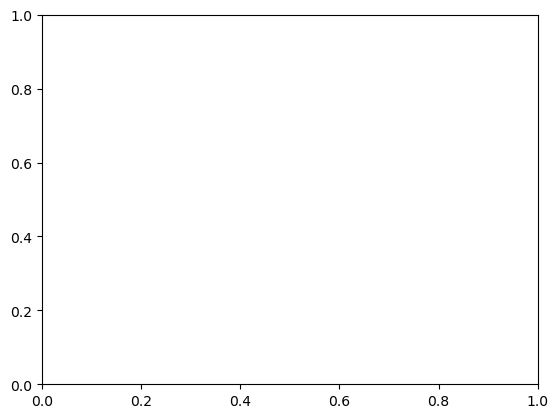

In [75]:
# Plot train and test loss curves
import matplotlib.pyplot as plt
x = np.arange(1, epochs+1)
fig, ax = plt.subplots(1, 1)
#ensor.detach().numpy()
print(train_loss_values[0].value())
train_losses = []
ax.plot(x, train_loss_values.numpy(), label="train loss")
#ax.plot(x, test_loss_values.detach().numpy(), label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross Entropy Loss")
ax.set_title("Train and test loss over 20 epochs for BERT E2E")
ax.legend()

In [22]:
#https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/#
f = open("Federalist Papers/all.txt", "r")
wholetext = []
wholetext.append(f.read())
f.close()
#analyzer=text_processing
#bow_transformer = CountVectorizer().fit(text_processing(wholetext))
bow_transformer = CountVectorizer().fit(wholetext)
# bow_transformer = CountVectorizer(analyzer=text_processing).fit(train_df.text.values)
# text_bow_train = bow_transformer.transform(train_df.text.values)
# text_bow_test = bow_transformer.transform(test_df.text.values)

#textprepath = "Federalist Papers/fed paper "
#wholetext = ""
#trains = np.zeros((85,bow_transformer.transform(['']).toarray().shape[1]))#[0] * 85
#texts = []
#for i in range(85):
    #f = open(f"{textprepath}{i + 1}.txt", "r")
    #text = f.read()
    #parts = text.split("\n", 1) #split out the first line
    #f.close()
    #parts = text_processing(parts[1])
    #print(parts)
    #wholetext += parts[0] + "\n"
    #print(i)
#bow_transformer = CountVectorizer().fit(text_processing(wholetext))
#trains = bow_transformer.transform(texts)

In [23]:
textprepath = "Federalist Papers/fed paper "
#trains = np.zeros((85,bow_transformer.transform(['']).toarray().shape[1]))#[0] * 85
texts = []
for i in range(85):
    f = open(f"{textprepath}{i + 1}.txt", "r")
    text = f.read()
    parts = text.split("\n", 1) #split out the first line
    f.close()
    parts = text_processing(parts[1])
    texts.append(parts)#[1])
    print(i)
trains = bow_transformer.transform(texts)

In [24]:
print(trains.shape)

In [61]:
print(trains[0]-trains[1])

  (0, 22)	-1
  (0, 132)	-1
  (0, 135)	1
  (0, 169)	1
  (0, 190)	1
  (0, 194)	-1
  (0, 209)	1
  (0, 218)	-1
  (0, 222)	-1
  (0, 235)	1
  (0, 247)	-1
  (0, 250)	-1
  (0, 256)	1
  (0, 268)	1
  (0, 275)	1
  (0, 280)	1
  (0, 281)	1
  (0, 328)	-1
  (0, 331)	2
  (0, 344)	1
  (0, 349)	1
  (0, 357)	-3
  (0, 358)	-1
  (0, 359)	-2
  (0, 363)	1
  :	:
  (0, 8825)	1
  (0, 8827)	-2
  (0, 8829)	-1
  (0, 8830)	-1
  (0, 8835)	-1
  (0, 8842)	23
  (0, 8849)	-2
  (0, 8850)	-2
  (0, 8851)	-1
  (0, 8853)	-1
  (0, 8854)	-1
  (0, 8857)	-1
  (0, 8859)	-7
  (0, 8865)	-2
  (0, 8876)	-1
  (0, 8880)	-1
  (0, 8889)	-2
  (0, 8890)	-3
  (0, 8904)	2
  (0, 8906)	-1
  (0, 8916)	1
  (0, 8917)	-2
  (0, 8923)	7
  (0, 8925)	10
  (0, 8928)	3


In [ ]:
#clf = make_pipeline(StandardScaler(), SVC())#= svm.SVC()
std = StandardScaler(with_mean=False)
clf = SVC()
std.fit(bow_transformer.transform(wholetext))#, with_mean=False)
scaled = std.transform(trains[known])
clf.fit(scaled, codes[known])

In [62]:
print(codes[known])

[1 2 2 2 2 1 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3
 3 3 3 3 3 3 3 3 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
#print(clf.predict((trains[17])))
#print(clf.predict(trains[63]))
#print(clf.predict(trains[50]))
for i in range(85):
    print(clf.predict(std.transform(trains[i])))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer() #make object of Count Vectorizer
corpus = [
      'This is a cat.',
      'It likes to roam in the garden',
      'It is black in color',
      'The cat does not like the dog.',
      ]
X = vectorizer.fit_transform(corpus)
#print(X)
#print(X) to see count given to words

#vectorizer.get_feature_names() == (
#['cat', 'color', 'roam', 'The', 'garden',
# 'dog', 'black', 'like', 'does', 'not',
# 'the', 'in', 'likes'])

#X.toarray()
#used to convert X into numpy array

#a = vectorizer.transform(['A new cat.', 'The cat does not like']).toarray()
a = vectorizer.transform(['']).toarray().shape[1]
# Checking it for a new document
print(a)

In [ ]:
SEED = 53113
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text into a list of tokens
    """
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text into a list of tokens
    """
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

In [ ]:
from torchtext.vocab.vocab_factory import build_vocab_from_iterator
def yield_de_tokens(data_iter):
    for pair in data_iter:
        yield tokenize_de(pair[0])


def yield_eng_tokens(data_iter):
    for pair in data_iter:
        yield tokenize_en(pair[1])
        
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

de_vocab = build_vocab_from_iterator(
    yield_de_tokens(train_data), min_freq=2,
    specials=special_symbols, special_first=True)

en_vocab = build_vocab_from_iterator(
    yield_eng_tokens(train_data), min_freq=2,
    specials=special_symbols, special_first=True)

en_vocab.set_default_index(UNK_IDX)
de_vocab.set_default_index(UNK_IDX)

In [ ]:
def de_transform(x):
    '''
    Return a list of indices corresponding to tokenized German text.
    '''
    return ([de_vocab['<bos>']] +
            [de_vocab[token] for token in tokenize_de(x)] +
            [de_vocab['<eos>']])

def en_transform(x):
    '''
    Return a list of indices corresponding to tokenized Englist text.
    '''
    return ([en_vocab['<bos>']] +
            [en_vocab[token] for token in tokenize_en(x)] +
            [en_vocab['<eos>']])

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    '''
    Collect samples from the data loader into a batch.
    Returns a tensor of shape {max length} x {batch size}
    '''
    de_lst, en_lst = [], []
    ge_max_len = 0
    en_max_len = 0

    for de, en in batch:
        de_lst.append(torch.LongTensor(de_transform(de)))
        en_lst.append(torch.LongTensor(en_transform(en)))

    de_batch = pad_sequence(de_lst, batch_first=False,
                            padding_value=PAD_IDX)
    en_batch = pad_sequence(en_lst, batch_first=False,
                            padding_value=PAD_IDX)
    return de_batch, en_batch

In [ ]:
class Encoder(nn.Module):
    def __init__(self, source_vocab_size, emb_dim, hid_dim, dropout_rate):
        super().__init__()
        self.hid_dim = hid_dim
        self.embed = nn.Embedding(source_vocab_size, emb_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(input_size = emb_dim, hidden_size = hid_dim)#, batch_first = True)
        ### WRITE YOUR CODE BELOW ### self.hid_dim = hid_dim

    def forward(self, src):
        a = self.embed(src)
        b = self.dropout(a)
        output, houtput = self.gru(b)#, hidden_input)
        return houtput 

In [ ]:
test = """*This is the Project Gutenberg Etext of The Federalist Papers.*
*****This file should be named feder16.txt or feder16.zip******
The release date of this Project Gutenberg Etext:  June 6, 1992
[Date last updated: July 10, 2004]

Corrected EDITIONS of our etexts get a new NUMBER, feder17.txt.
VERSIONS based on separate sources get new LETTER, feder10a.txt.


DISCLAIMER"""
print(text_processing(test))
print("text_processing(wholetext)")